In [1]:
# FLORIS tools notebook - this defines all of the tools the FLORIS can do (see diagram)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import imp
import time

import florisCoreFunctions.main as main
import Turbines.NREL5MW.NREL5MW as NREL5MW



# Input Data

In [3]:
inputData = dict()

# =============================================================================================
#                              Choose Turbine
# =============================================================================================
# turbine info
inputData['TurbineInfo']        = NREL5MW.turbineProperties()

# eventually get rid of these parameters
D     = inputData['TurbineInfo']['rotorDiameter']
HH    = inputData['TurbineInfo']['hubHeight']
beta  = inputData['TurbineInfo']['bladePitch']
gamma = inputData['TurbineInfo']['yawAngle']
phi   = inputData['TurbineInfo']['tilt']
pP    = inputData['TurbineInfo']['pP']
pT    = inputData['TurbineInfo']['pT']
gE    = inputData['TurbineInfo']['generatorEfficiency']
B     = inputData['TurbineInfo']['NumBlades']
TSR   = inputData['TurbineInfo']['TSR']


# =============================================================================================
#                              Turbine Locations
# =============================================================================================
# turbine locations - example 2x2 wind farm
inputData['turbineX'] = [500.0]
inputData['turbineY'] = [250.0]
nTurbs                = len(inputData['turbineX']) 
inputData['turbineZ'] = HH*np.ones(nTurbs)

# =============================================================================================
#                              Atmospheric Conditions
# =============================================================================================

Uinf = 7.0

# atmospheric conditions
inputData['airDensity']          = 1.225           # air density
inputData['windSpeed']           = Uinf            # wind speed [m/s]
inputData['windDirection']       = 270.0           # wind direction [deg] (compass degrees)
inputData['veer']                = 0.0             # veer component [deg]
inputData['turbulenceIntensity'] = 0.1             # turbulence intensity [-] ex: 0.1 is 10% turbulence intensity
inputData['shear']               = 0.12            # shear exponent (0.14 -> neutral)


# =============================================================================================
#                              Turbine Parameters
# =============================================================================================
# individual turbine parameters (update Ct and Cp)
inputData['rotorDiameter']       = [D for i in range(nTurbs)]         # rotor diameter [m]
inputData['hubHeight']           = [HH for i in range(nTurbs)]        # hub height [m]
inputData['pP']                  = [pP for i in range(0,nTurbs)]      # power adjustment to the cosine rule [-]
inputData['pT']                  = [2.07 for i in range(0,nTurbs)]    # power adjustment to the cosine rule [-]
inputData['generatorEfficiency'] = [gE for i in range(nTurbs)]        # generator efficiency [-]
inputData['NumBlades']           = [B for i in range(nTurbs)]         # number of blades [-]
inputData['TSR']                 = [TSR for i in range(nTurbs)]       # tip-speed ratio [-]

#turbine controls
Cp,Ct                           = NREL5MW.determineCpCt(inputData['TurbineInfo']['CpCtWindSpeed'],inputData['windSpeed'])
inputData['yawAngles']          = [gamma for i in range(nTurbs)]      # yaw angles [deg]
inputData['tilt']               = [phi for i in range(nTurbs)]        # tilt angle [deg]
inputData['Cp']                 = [Cp for i in range(nTurbs)]         # power coefficient [-]
inputData['bladePitch']         = [beta for i in range(nTurbs)]       # collective blade pitch angle 
inputData['Ct']                 = [Ct for i in range(nTurbs)]         # thrust coefficient [-] 

# =============================================================================================
#                               Choose Wake Model
# =============================================================================================
# wake models
inputData['WakeModel']          = 2                                   # 0 = Jensen, 1 = FLORIS, 2 = Gaussian

# =============================================================================================
#                               Choose wake combination
# =============================================================================================
# velocity deficity
inputData['combineWakes']       = 2                                   # 0 = freestream linear, 1 = local velocity linear, 2 = sum of squares freestream, 3 = sum of squares local velocity 


# =============================================================================================
#                               Wake Parameters (FLORIS, GAUSS)
# =============================================================================================
# wake parameters (Jensen and FLORIS)
inputData['wakeDeflection'] = [0.17 for i in range(nTurbs)]    # standard in literature is 0.17
inputData['wakeExpansion']  = [0.05 for i in range(nTurbs)]    # wake expansion coefficient
inputData['ad']             = -4.5                             # lateral wake displacement bias parameter (a + bx)
inputData['bd']             = -0.01                            # lateral wake displacement bias parameter (a + bx)
inputData['aT']             = 0.0                              # vertical wake displacement bias parameter (a + bx)
inputData['bT']             = 0.0                              # vertical wake displacement bias parameter
inputData['me']             = [-0.5,0.3,1.0]                   # expansion of each region of the wake
inputData['MU']             = [0.5,1.,5.5]                     # determine velocity of each region in the wake
inputData['aU']             = 12.0                             # wake velocity parameter (a + b*yaw)                                                    
inputData['bU']             = 1.3                              # wake velocity parameter (a + b*yaw) 

# wake parameters GAUSS
inputData['ka'] = 0.3871                    # wake expansion parameter (ka*TI + kb)                     
inputData['kb'] = 0.004                     # wake expansion parameter (ka*TI + kb)
inputData['alpha'] = 0.58                   # near wake parameter
inputData['beta'] = 0.077                   # near wake parameter

inputData['TIdistance'] = 15*D              # threshold distance of turbines to include in "added turbulence"
inputData['TIa'] = 0.73                     # magnitude of turbulence added
inputData['TIb'] = 0.8325                   # contribution of turbine operation
inputData['TIc'] = 0.0325                   # contribution of ambient turbulence intensity
inputData['TId'] = -0.32                    # contribution of downstream distance from turbine

# =============================================================================================
#                                      Optimization
# =============================================================================================

# optimization options
inputData['axial_opt']        = False       # True turns on thrust control
inputData['yaw_opt']          = False       # True turns on wake steering

# NOTE: large-scale optimization techniques have not been enabled in this version, but will be released in future versions

# constraints on controls
inputData['minYaw']           = [0.0]        # minimum yaw angles considered in wake steering optimization
inputData['maxYaw']           = [25.0]       # maximum yaw angles considered in wake steering optimization

# =============================================================================================
#                                       Visualization
# =============================================================================================
# domain for plotting
inputData['rotorPts']           = 16          # number of points evaluated on the turbine rotor 
inputData['avgCube']            = False       # True: take cube root of the average of cubed wind speed, False: take the average of the wind speed

inputData['xLen']               = [np.min(inputData['turbineX'])-2*D,np.max(inputData['turbineX'])+15*D] # x domain (min,max)
inputData['yLen']               = [np.min(inputData['turbineY'])-2*D,np.max(inputData['turbineY'])+2*D]  # y domain (min,max)
inputData['zLen'] 				= [0.0,2*HH]                                                             # z domain (min,max)

inputData['outputFlowField']     = False        # output full flow field
inputData['visualizeHorizontal'] = False        # visualize horizontal flow field at hub height       
inputData['nSamplesX']           = 200          # resolution of the plot in the x direction
inputData['nSamplesY']           = 200          # resolution of the plot in the y direction
inputData['nSamplesZ']           = 50           # resoltuion of the plot in the z direction

# plot cut through slices (parallel with the rotor)
inputData['cutThrough']         = False
inputData['cutTurbID']          = 0
inputData['downLocs']           = [2*D]

# =============================================================================================
#                                       Lidar
# =============================================================================================

# Lidar module based on the first turbine - University of Stuttgard Lidar model
# only one lidar can be used currently for one turbine
inputData['Lidar']              = False                         # Turn on lidar module and output flow field from 5 downstream locations 
inputData['turbineLidar']       = 0                             # identify the turbine that the Lidar is on
inputData['xLidar']             = pd.read_csv('LiDAR/xLoc.csv') # x locations of the lidar measurements
inputData['yLidar']             = pd.read_csv('LiDAR/yLoc.csv') # y locations of the lidar measurements
inputData['zLidar']             = pd.read_csv('LiDAR/zLoc.csv') # z locations of the lidar measurements
inputData['LidarParams']        = 'LiDAR/Liss2Grid7x7widescreen_1d000_0d450_2d800_10000_1d600_NRELGE_Continuous_Parameter_JENExport.mat'
inputData['LidarTrajectory']    = 'LiDAR/Liss2Grid7x7widescreen_1d000_0d450_2d800_10000_1d600_NRELGE_Continuous_JENExport.mat'

# =============================================================================================
#                                      Output points
# =============================================================================================
# select points to output velocity (if you want the full flow field, you should set outputFlowField to True rather than use this)
inputData['xPts'] = np.concatenate(inputData['xLidar'].values) + inputData['turbineX'][inputData['turbineLidar']]
inputData['yPts'] = np.concatenate(inputData['yLidar'].values) + inputData['turbineY'][inputData['turbineLidar']]
inputData['zPts'] = np.concatenate(inputData['zLidar'].values) + inputData['turbineZ'][inputData['turbineLidar']]
inputData['points'] = False    # must set this to true if you want points 



# Output Data

In [4]:
# outputs:

# =========================================================
#                   OUTPUT FLOW FIELD
# =========================================================
#     outputData['Ufield']   -> 2D flow field
#     outputData['xLen']     -> x vector corresponding to flow field
#     outputData['yLen]      -> y vector corresponding to flow field
#     outputData['powerOut'] -> power output of each turbine
#     outputData['Ueff']     -> effective velocity at each turbine

# =========================================================
#                       Optimization 
# =========================================================
#     outputData['yawAngles']  -> yaw angles if inputData['yaw_opt'] set to true
#
#     outputData['bladePitch'] -> blade pitch if inputData['axial_opt'] set to true
#     outputData['Cp_opt']     -> optimal Cp 
#     outputData['Ct_opt']     -> optimal Ct

#     outputData['powerOut']   -> power output of each turbine
#     outputData['Ueff']       -> effective velocity at each turbine

# =========================================================
#                          Lidar
# =========================================================
#     outputData['Ufield']   -> 2D flow field
#     outputData['X']        -> x grid corresponding to flow field
#     outputData['Y']        -> y grid corresponding to flow field
#     outputData['Z']        -> z grid corresponding to Ufield
#     outputData['powerOut'] -> power output of each turbine
#     outputData['Ueff']     -> effective velocity at each turbine

# =========================================================
#                          Points
# =========================================================
#     outputData['Upts']     -> velocity corresponding to input points
#     outputData['powerOut'] -> power output of each turbine
#     outputData['Ueff']     -> effective velocity at each turbine

# =========================================================
#                          Default
# =========================================================
#     outputData['powerOut'] -> power output of each turbine
#     outputData['Ueff']     -> effective velocity at each turbine



## Example 0: Extract Velocity and Power Information (no plotting) 

In [5]:
# example (basic) - get velocity and power out

inputData['visualizeHorizontal'] = False
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = False
outputData = main.windPlant(inputData)

print('Effective Velocities')
for i in range(nTurbs):
    print('Turbine ', i, ' velocity = ', outputData['Ueff'][i])

print('Power')
for i in range(nTurbs):
    print('Turbine ', i, ' power = ', outputData['powerOut'][i])
    

Effective Velocities
Turbine  0  velocity =  6.97936532962
Power
Turbine  0  power =  1162592.50473


# Example 1: Visualization

## Example 1a: Visualization with Gaussian model (horizontal slice)

Plotting Flow Field Horizontal...



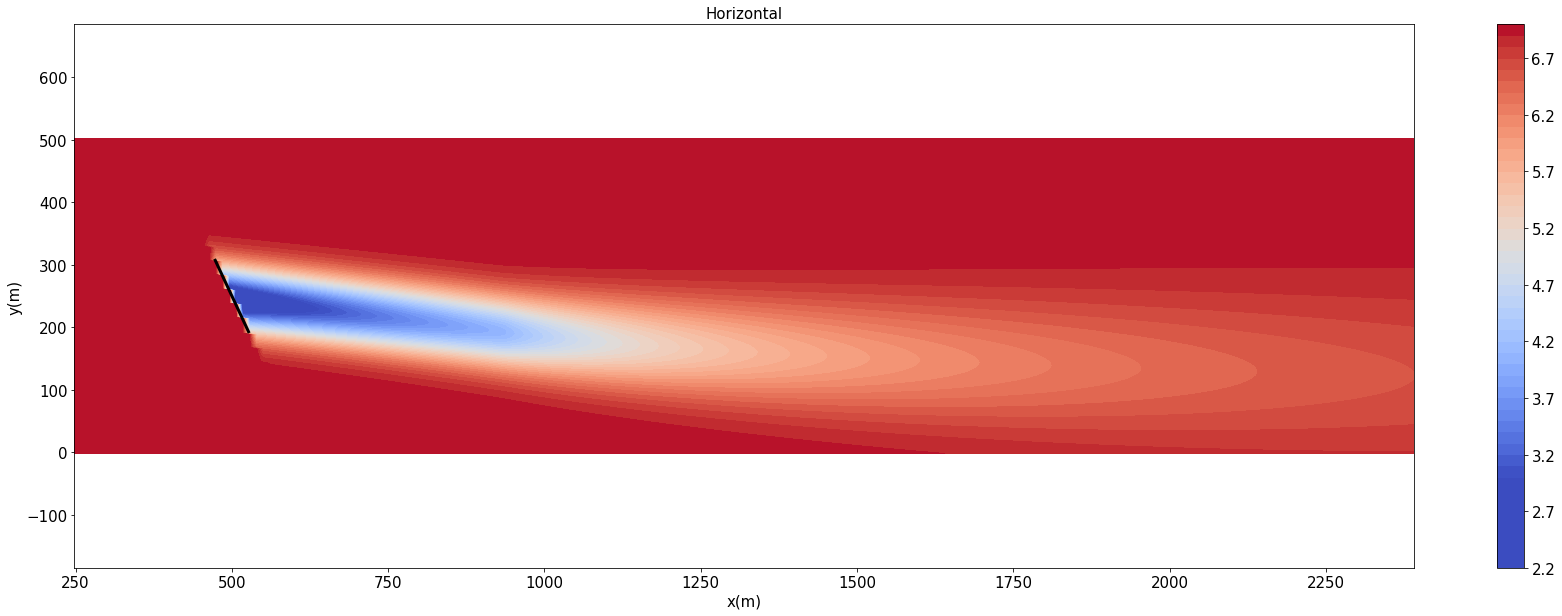

In [6]:
# no yaw
inputData['visualizeHorizontal'] = True
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = False
inputData['WakeModel'] = 2
inputData['yawAngles'] = np.zeros(nTurbs)

#outputData = main.windPlant(inputData)

# yaw
inputData['visualizeHorizontal'] = True
inputData['yawAngles'][0] = 25.0

outputData = main.windPlant(inputData)

## Example 1b: Visualization with original FLORIS model (horizontal slice)

Plotting Flow Field Horizontal...

Plotting Flow Field Horizontal...



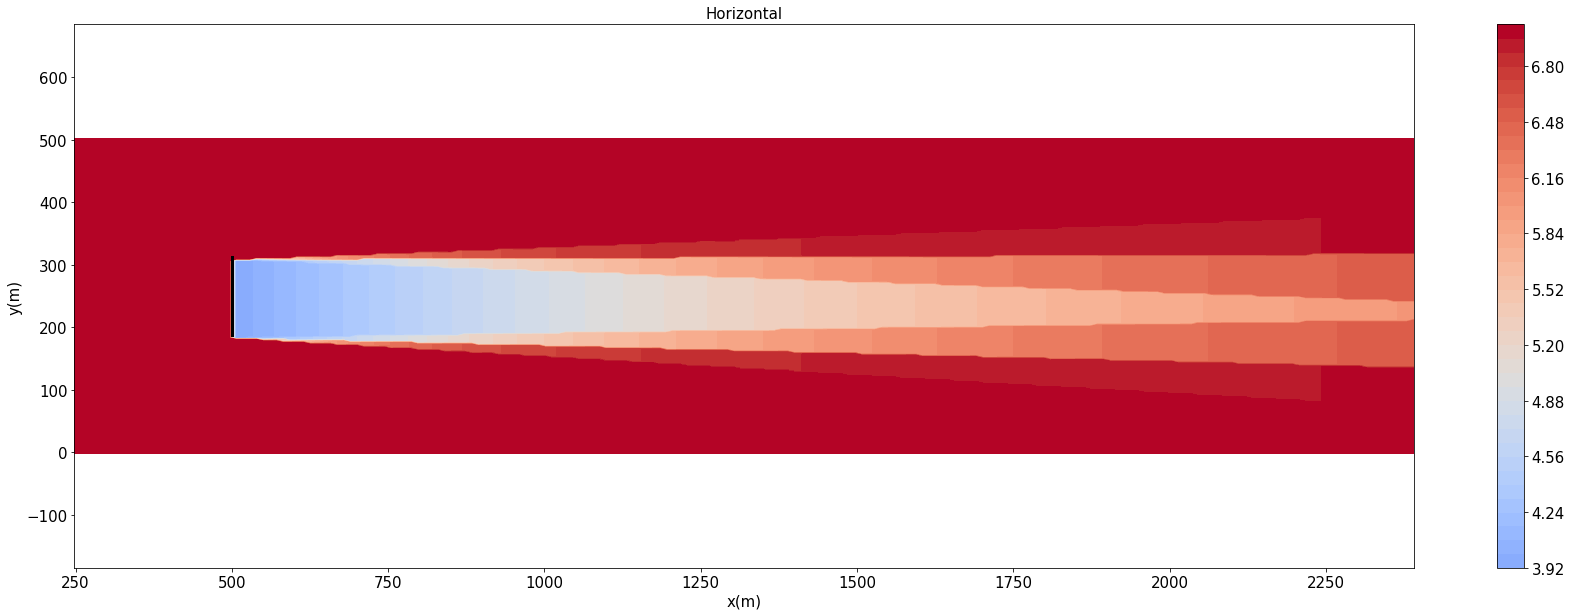

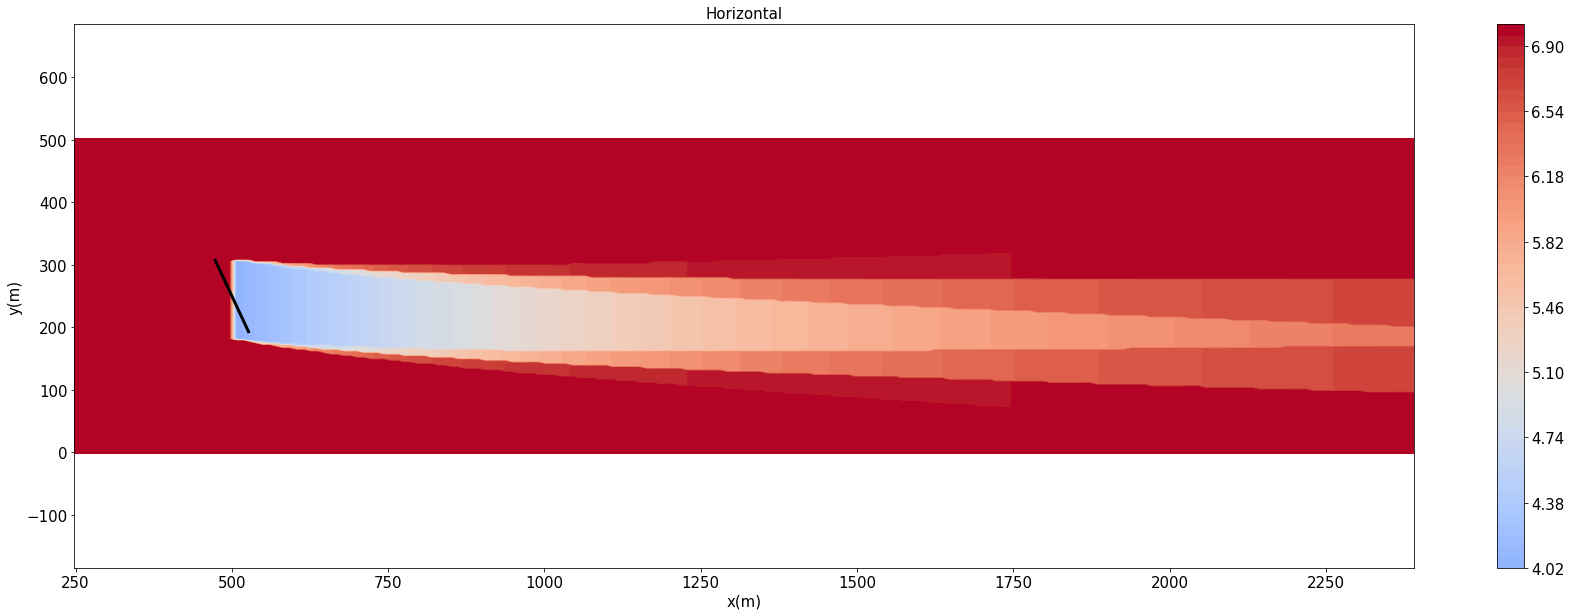

In [7]:
# no yaw

inputData['visualizeHorizontal'] = True
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = False
inputData['WakeModel'] = 1
inputData['yawAngles'] = np.zeros(nTurbs)

outputData = main.windPlant(inputData)

# yaw
inputData['visualizeHorizontal'] = True
inputData['yawAngles'][0] = 25.0

outputData = main.windPlant(inputData)

## Example 1c: Visualization with Jensen model (horizontal)

Plotting Flow Field Horizontal...

Plotting Flow Field Horizontal...



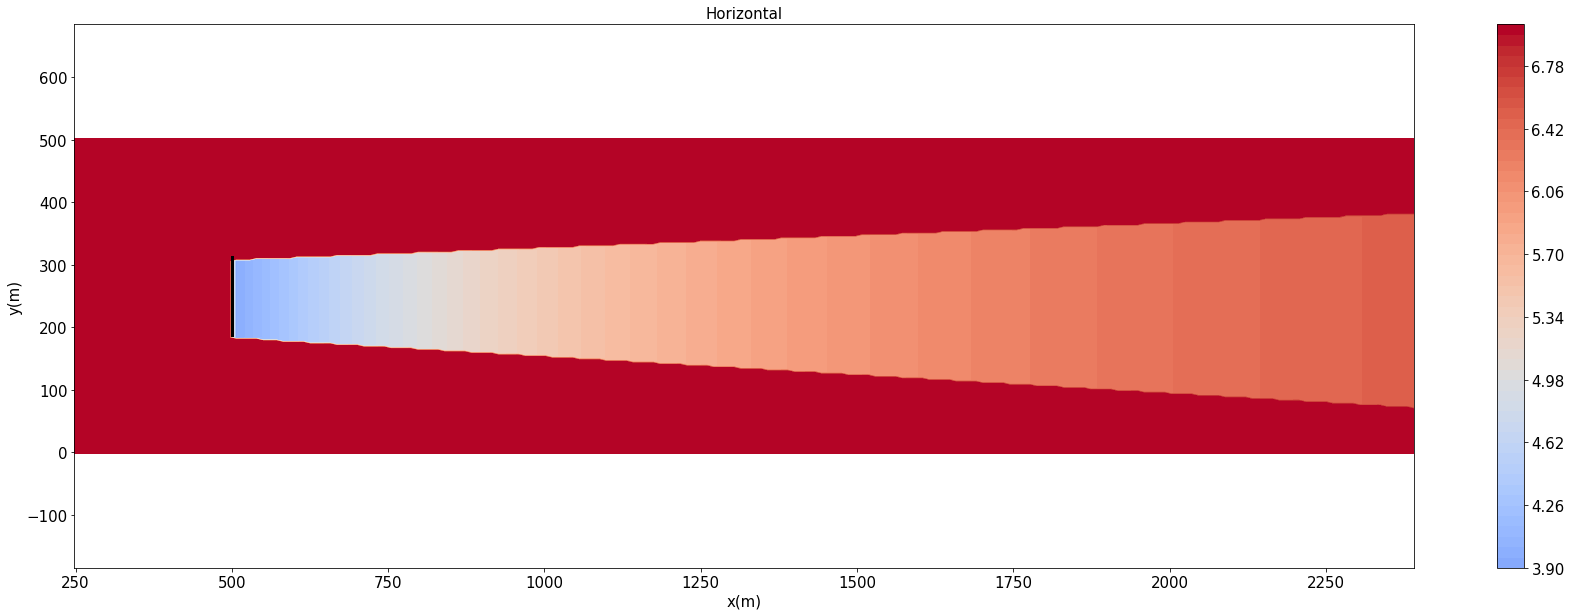

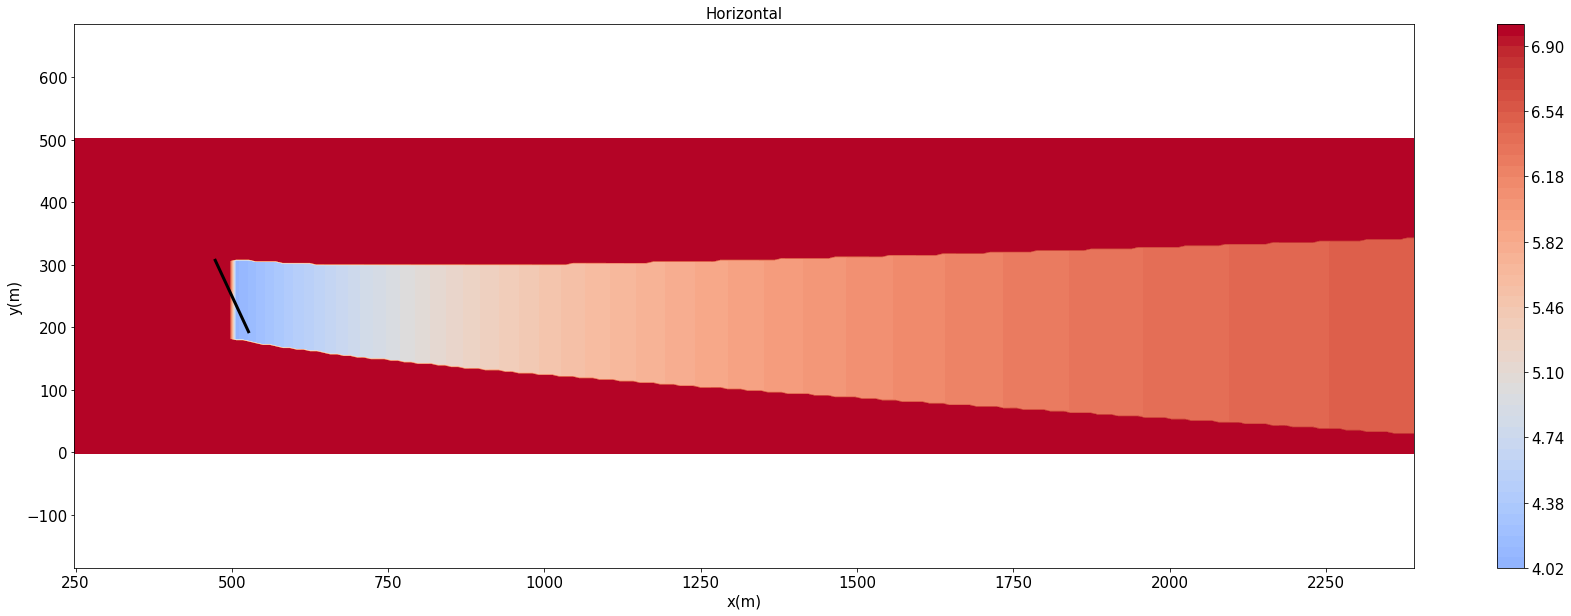

In [8]:
# no yaw

inputData['visualizeHorizontal'] = True
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = False
inputData['WakeModel'] = 0
inputData['yawAngles'] = np.zeros(nTurbs)

outputData = main.windPlant(inputData)

# yaw
inputData['visualizeHorizontal'] = True
inputData['yawAngles'][0] = 25.0

outputData = main.windPlant(inputData)

# Example 2: wake steering optimization

In [ ]:
# wake steering optimization with the Gaussian Wake model

inputData['visualizeHorizontal'] = False
inputData['yaw_opt']             = True
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = False
inputData['WakeModel'] = 2

inputData['yawAngles'] = np.zeros(nTurbs)
inputData['bladePitch'] = np.zeros(nTurbs)

outputData = main.windPlant(inputData)

# Example 3: Thrust optimization 

In [ ]:
# thrust control using the Gaussian wake model

inputData['visualizeHorizontal'] = False
inputData['yaw_opt']             = False
inputData['axial_opt']           = True
inputData['Lidar']               = False
inputData['points']              = False
inputData['WakeModel'] = 2

inputData['yawAngles'] = np.zeros(nTurbs)
inputData['bladePitch'] = np.zeros(nTurbs)

outputData = main.windPlant(inputData)

# Example 4: Visualization of the Lidar module with Gaussian Wake Model

In [9]:
# horizontal slice visualization

inputData['visualizeHorizontal'] = False
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = True
inputData['points']              = False
inputData['cutThrough']          = False
inputData['yawAngles'][0] = 0.0
inputData['WakeModel'] = 2

inputData['bladePitch'] = np.zeros(nTurbs)
inputData['turbineLidar'] = 0                   # indexing starts at 0 in python
n1 = time.time()
outputData = main.windPlant(inputData)
n2 = time.time()

print('Total time = ', n2-n1, 's')

inputData['points'] = True
inputData['Lidar'] = False
outputDataPts = main.windPlant(inputData)


Total time =  20.201067209243774 s


In [10]:
x_W,y_W,z_W = utilities.getWindCoords(inputData)
plt.figure()
plt.scatter(y_W[0::5],z_W[0::5],color='r')

Trajectory = scipy.io.loadmat(inputData['LidarTrajectory'])
x_L = np.concatenate(Trajectory['Trajectory'][0][0]['x_L_AllDistances'])
y_L = np.concatenate(Trajectory['Trajectory'][0][0]['y_L_AllDistances'])
z_L = np.concatenate(Trajectory['Trajectory'][0][0]['z_L_AllDistances']) 
plt.figure()
plt.scatter(y_L[0::5],z_L[0::5])

NameError: name 'utilities' is not defined

In [ ]:
outputData['vlos'][0::5]

In [ ]:
# plot the outcomes and the difference

plt.figure(figsize=(20,3))
nPts = 49
for i in range(5):
    plt.subplot(1,5,i+1)
    strLoc = 'loc' + str(i+1)
    #yPlot = inputData['yLidar'][strLoc]
    #zPlot = inputData['zLidar'][strLoc] + inputData['hubHeight'][inputData['turbineLidar']]
    yPlot = y_W[i::5]
    zPlot = z_W[i::5]
    
    #Uplot = outputData['vlos'][i*nPts:(i+1)*nPts]
    Uplot = outputData['vlos'][i::5]
    
    #yPlot = y_W[rangeGate::5]
    #zPlot = z_W[rangeGate::5]
    #Uplot = outputData['vlos'][rangeGate::5]

    # Interpolate the data
    #resolution = 100
    #xInt = np.linspace(min(yPlot), max(yPlot), resolution)
    #yInt = np.linspace(min(zPlot), max(zPlot), resolution)
    #xMesh, yMesh = np.meshgrid(xInt, yInt)
    
    #uMesh = griddata(np.column_stack([yPlot, zPlot]), Uplot,(xMesh.flatten(), yMesh.flatten()), method='cubic')
    #uMesh = uMesh.reshape(resolution,resolution)
    
    yi = np.linspace(np.min(yPlot),np.max(yPlot),50)
    zi = np.linspace(np.min(zPlot),np.max(zPlot),50)
    yi,zi = np.meshgrid(yi,zi)
    
    rbf = scipy.interpolate.Rbf(yPlot,zPlot,Uplot,function='linear')
    ui = rbf(yi,zi)
    
    plt.contourf(yi,zi,ui,cmap='coolwarm',vmin=0,vmax=Uinf)
    #plt.contourf(xInt,yInt,uMesh,cmap='coolwarm',vmin=0,vmax=Uinf)
    plt.title(strLoc,fontsize=12)
    plt.xlabel('y (m)', fontsize=12)
    if i == 0:
        plt.ylabel('z (m)', fontsize=12)
    #plt.xlim([-100,100])
    #plt.ylim([30,150])
    plt.colorbar()

In [ ]:
plt.figure(figsize=(20,3))
nPts = 49
for i in range(5):
    plt.subplot(1,5,i+1)
    strLoc = 'loc' + str(i+1)
    yPlot = inputData['yLidar'][strLoc]
    zPlot = inputData['zLidar'][strLoc] + inputData['hubHeight'][inputData['turbineLidar']]
    
    #Uplot = outputDataPts['Upts'][i*nPts:(i+1)*nPts]
    Uplot = outputDataPts['Upts'][i::5]
    
    yi = np.linspace(np.min(yPlot),np.max(yPlot),50)
    zi = np.linspace(np.min(zPlot),np.max(zPlot),50)
    yi,zi = np.meshgrid(yi,zi)
    
    rbf = scipy.interpolate.Rbf(yPlot,zPlot,Uplot,function='linear')
    ui = rbf(yi,zi)
    
    plt.contourf(-yi,zi,ui,cmap='coolwarm',vmin=0,vmax=Uinf)
    plt.title(strLoc,fontsize=12)
    plt.xlabel('y (m)', fontsize=12)
    if i == 0:
        plt.ylabel('z (m)', fontsize=12)
    plt.xlim([-100,100])
    plt.ylim([30,150])
    plt.colorbar()

In [12]:
plt.figure(figsize=(20,2))
nPts = 49
for i in range(5):
    plt.subplot(1,5,i+1)
    strLoc = 'loc' + str(i+1)
    yPlot = inputData['yLidar'][strLoc]
    zPlot = inputData['zLidar'][strLoc] + inputData['hubHeight'][inputData['turbineLidar']]
    
    Uplot = outputDataPts['Upts'][i::5] - outputData['vlos'][i::5]
    
    yi = np.linspace(np.min(yPlot),np.max(yPlot),20)
    zi = np.linspace(np.min(zPlot),np.max(zPlot),20)
    yi,zi = np.meshgrid(yi,zi)
    
    rbf = scipy.interpolate.Rbf(yPlot,zPlot,Uplot,function='linear')
    ui = rbf(yi,zi)
    
    plt.contourf(yi,zi,ui,cmap='coolwarm')
    plt.title(strLoc,fontsize=12)
    plt.xlabel('y (m)', fontsize=12)
    if i == 0:
        plt.ylabel('z (m)', fontsize=12)
    plt.xlim([-100,100])
    plt.ylim([30,150])
    plt.colorbar()

NameError: name 'plt' is not defined

In [ ]:
Parameter = scipy.io.loadmat(inputData['LidarParams'])
Yaw = Parameter['Parameter'][0][0][0]['YawAngle'][0][0][0]
Pitch = Parameter['Parameter'][0][0][0]['PitchAngle'][0][0][0]
Roll = Parameter['Parameter'][0][0][0]['RollAngle'][0][0][0]
PositionLinW = Parameter['Parameter'][0][0][0]['PositionLinI'][0][0][0]

# Example 4: Use 'points' to visualize the output of the lidar

In [ ]:
# Note: if you have a different lidar setup, this approach can be used to extract the velocity field for the specific lidar

In [11]:
# get streamwise velocity from specified points 

inputData['visualizeHorizontal'] = False
inputData['yaw_opt']             = False
inputData['axial_opt']           = False
inputData['Lidar']               = False
inputData['points']              = True

inputData['yawAngles'] = np.zeros(nTurbs)
inputData['bladePitch'] = np.zeros(nTurbs)

outputData = main.windPlant(inputData)

# output streamwise velocity points that correspond to inputData['xPts'], inputData['yPts'], and inputData['zPts']
Upts = outputData['Upts']

idx = 0
print('velocity at ', inputData['xPts'][idx], inputData['yPts'][idx], inputData['zPts'][idx], '=', Upts[idx],'m/s')


velocity at  577.0 250.0 90.0 = 1.51417391657 m/s
